<a href="https://colab.research.google.com/github/masonnystrom/DS-Unit-2-Kaggle-Challenge/blob/master/module2-random-forests/LS_DS_222_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

# Random Forests

## Assignment
- [ ] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [ ] Continue to participate in our Kaggle challenge.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features.
- [ ] Try Ordinal Encoding.
- [ ] Try a Random Forest Classifier.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [ ] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [ ] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_


### More Categorical Encodings

**1.** The article **[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)** mentions 4 encodings:

- **"Categorical Encoding":** This means using the raw categorical values as-is, not encoded. Scikit-learn doesn't support this, but some tree algorithm implementations do. For example, [Catboost](https://catboost.ai/), or R's [rpart](https://cran.r-project.org/web/packages/rpart/index.html) package.
- **Numeric Encoding:** Synonymous with Label Encoding, or "Ordinal" Encoding with random order. We can use [category_encoders.OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html).
- **One-Hot Encoding:** We can use [category_encoders.OneHotEncoder](http://contrib.scikit-learn.org/categorical-encoding/onehot.html).
- **Binary Encoding:** We can use [category_encoders.BinaryEncoder](http://contrib.scikit-learn.org/categorical-encoding/binary.html).


**2.** The short video 
**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)** introduces an interesting idea: use both X _and_ y to encode categoricals.

Category Encoders has multiple implementations of this general concept:

- [CatBoost Encoder](http://contrib.scikit-learn.org/categorical-encoding/catboost.html)
- [James-Stein Encoder](http://contrib.scikit-learn.org/categorical-encoding/jamesstein.html)
- [Leave One Out](http://contrib.scikit-learn.org/categorical-encoding/leaveoneout.html)
- [M-estimate](http://contrib.scikit-learn.org/categorical-encoding/mestimate.html)
- [Target Encoder](http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html)
- [Weight of Evidence](http://contrib.scikit-learn.org/categorical-encoding/woe.html)

Category Encoder's mean encoding implementations work for regression problems or binary classification problems. 

For multi-class classification problems, you will need to temporarily reformulate it as binary classification. For example:

```python
encoder = ce.TargetEncoder(min_samples_leaf=..., smoothing=...) # Both parameters > 1 to avoid overfitting
X_train_encoded = encoder.fit_transform(X_train, y_train=='functional')
X_val_encoded = encoder.transform(X_train, y_val=='functional')
```

For this reason, mean encoding won't work well within pipelines for multi-class classification problems.

**3.** The **[dirty_cat](https://dirty-cat.github.io/stable/)** library has a Target Encoder implementation that works with multi-class classification.

```python
 dirty_cat.TargetEncoder(clf_type='multiclass-clf')
```
It also implements an interesting idea called ["Similarity Encoder" for dirty categories](https://www.slideshare.net/GaelVaroquaux/machine-learning-on-non-curated-data-154905090).

However, it seems like dirty_cat doesn't handle missing values or unknown categories as well as category_encoders does. And you may need to use it with one column at a time, instead of with your whole dataframe.

**4. [Embeddings](https://www.kaggle.com/learn/embeddings)** can work well with sparse / high cardinality categoricals.

_**I hope it’s not too frustrating or confusing that there’s not one “canonical” way to encode categoricals. It’s an active area of research and experimentation! Maybe you can make your own contributions!**_

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [601]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [602]:
# get val set 
train, val = train_test_split(train, train_size=.80, test_size=.20,
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape

((47520, 41), (11880, 41))

In [0]:
def wrangle(X):
  """wrangle function for data"""
  X = X.copy()
  # small latitutde values
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # cols with zeros
  cols_with_zeros = ['longitude', 'latitude', 'construction_year',
                     'gps_height', 'population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0,np.nan)
    X[col+'_MISSING'] = X[col].isnull()
  
  # drop duplicates
  duplicates = ['quantity_group', 'payment_type', 'water_quality', 
                'source_type', 'waterpoint_type_group','extraction_type_group',
                'extraction_type','management']
  X = X.drop(columns=duplicates)

  # drop recorded by(only one group recorded everything) and id(always varies/random)
  unusable_variance = ['recorded_by']
  X = X.drop(columns=unusable_variance)

  #convert to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  # create month, year columns
  X['year_recorded'] = X['date_recorded'].dt.year 
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day 
  X = X.drop(columns='date_recorded')

  #Engineer feature: how many years since the construction
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  # wrangel and return dataframe
  return X 


In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
#Set the features
target = 'status_group'

train_features = train.drop(columns=[target, 'id'])

# numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 50].index.tolist()

features = numeric_features + categorical_features

# Categorical Encoding RF

In [0]:
# # X matrices and y vector

# X_train = train[features]
# y_train = train[target]

# X_val = val[features]
# y_val = val[target]

# X_test = test

In [0]:
# import category_encoders as ce
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import make_pipeline

In [0]:
# pipeline = make_pipeline(
#     ce.OneHotEncoder(use_cat_names=True),
#     SimpleImputer(strategy='mean'),
#     RandomForestClassifier(random_state=0, n_jobs=-1)
# )

# pipeline.fit(X_train, y_train)
# print('Validation Accuracy', pipeline.score(X_val, y_val))

In [0]:
# # get importances
# %matplotlib inline
# import matplotlib.pyplot as plt

# # get encoded values
# encoder = pipeline.named_steps['onehotencoder']
# encoded = encoder.transform(X_train)

# # get importances
# rf = pipeline.named_steps['randomforestclassifier']
# importances = pd.Series(rf.feature_importances_, encoded.columns)

In [0]:
# plot top 20 
# n = 30
# plt.figure(figsize=(10, n/2))
# plt.title(f'Top {n} features')
# importances.sort_values()[-n:].plot.barh();


# Using Ordinal Encoding

In [0]:
# X_train = train.drop(columns=target)
# y_train = train[target]

# X_val = val.drop(columns=target)
# y_val = val[target]

# X_test = test

In [611]:
# baseline for rf and Ordinal Encoding 
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=0, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Validation Accuracy: 0.8101010101010101


# Testing for Kaggle

### Feature engineering

In [0]:
# Get a list of the top funders
top_funders = train['funder'].value_counts()[:30].index
 
train.loc[~train['funder'].isin(top_funders), 'funder'] = 'OTHER'
val.loc[~val['funder'].isin(top_funders), 'funder'] = 'OTHER'
test.loc[~test['funder'].isin(top_funders), 'funder'] = 'OTHER'

In [0]:
top_wpt = train['wpt_name'].value_counts()[:30].index

train.loc[~train['wpt_name'].isin(top_wpt), 'wpt_name'] = 'OTHER'
val.loc[~val['wpt_name'].isin(top_wpt), 'wpt_name'] = 'OTHER'
test.loc[~test['wpt_name'].isin(top_wpt), 'wpt_name'] = 'OTHER'


In [0]:
top_installer = train['installer'].value_counts()[:50].index

train.loc[~train['installer'].isin(top_installer), 'installer'] = 'OTHER'
val.loc[~val['installer'].isin(top_installer), 'installer'] = 'OTHER'
test.loc[~test['installer'].isin(top_installer), 'installer'] = 'OTHER'

In [0]:
top_subvillage = train['subvillage'].value_counts()[:200].index
 
train.loc[~train['subvillage'].isin(top_subvillage), 'subvillage'] = 'OTHER'
val.loc[~val['subvillage'].isin(top_subvillage), 'subvillage'] = 'OTHER'
test.loc[~test['subvillage'].isin(top_subvillage), 'subvillage'] = 'OTHER'

In [0]:
top_ward = train['ward'].value_counts()[:50].index

train.loc[~train['ward'].isin(top_ward), 'ward'] = 'OTHER'
val.loc[~val['ward'].isin(top_ward), 'ward'] = 'OTHER'
test.loc[~test['ward'].isin(top_ward), 'ward'] = 'OTHER'

In [0]:
top_num_private = train['num_private'].value_counts()[:30].index
 
train.loc[~train['num_private'].isin(top_num_private), 'num_private'] = 'OTHER'
val.loc[~val['num_private'].isin(top_num_private), 'num_private'] = 'OTHER'
test.loc[~test['num_private'].isin(top_num_private), 'num_private'] = 'OTHER'

In [0]:
top_scheme_name = train['scheme_name'].value_counts()[:30].index
 
train.loc[~train['scheme_name'].isin(top_scheme_name), 'scheme_name'] = 'OTHER'
val.loc[~val['scheme_name'].isin(top_scheme_name), 'scheme_name'] = 'OTHER'
test.loc[~test['scheme_name'].isin(top_scheme_name), 'scheme_name'] = 'OTHER'

In [0]:
top_lga = train['lga'].value_counts()[:50].index
 
train.loc[~train['lga'].isin(top_lga), 'lga'] = 'OTHER'
val.loc[~val['lga'].isin(top_lga), 'lga'] = 'OTHER'
test.loc[~test['lga'].isin(top_lga), 'lga'] = 'OTHER'

In [636]:
X_train.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'extraction_type_class', 'management_group', 'payment', 'quality_group',
       'quantity', 'source', 'source_class', 'waterpoint_type',
       'longitude_MISSING', 'latitude_MISSING', 'construction_year_MISSING',
       'gps_height_MISSING', 'population_MISSING', 'year_recorded',
       'month_recorded', 'day_recorded', 'years', 'years_MISSING'],
      dtype='object')

In [0]:
target = 'status_group'
X_train = train.drop(columns= [target, 'id','construction_year'])
y_train = train[target]

X_val = val.drop(columns= [target, 'id','construction_year'])
y_val = val[target]

X_test = test.drop(columns=['id','construction_year'])

In [635]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=210, max_features="auto", 
                           random_state=42, n_jobs=-1, warm_start=False,
                           min_samples_leaf=2) 
)
pipeline.fit(X_train, y_train)
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.9283038720538721
Validation Accuracy: 0.8160774410774411


.816

In [0]:
y_pred = pipeline.predict(X_test) 

# make submission
submission = test[['id']].copy()
submission['status_group'] = y_pred

In [634]:
submission.to_csv('waterpump-submission-06.csv', index=False)
sub_df = pd.read_csv('/content/waterpump-submission-06.csv')
sub_df.shape

(14358, 2)

# Random Forrest Important Features

In [0]:
# get importances
%matplotlib inline
import matplotlib.pyplot as plt

# get encoded values
encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)

# get importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

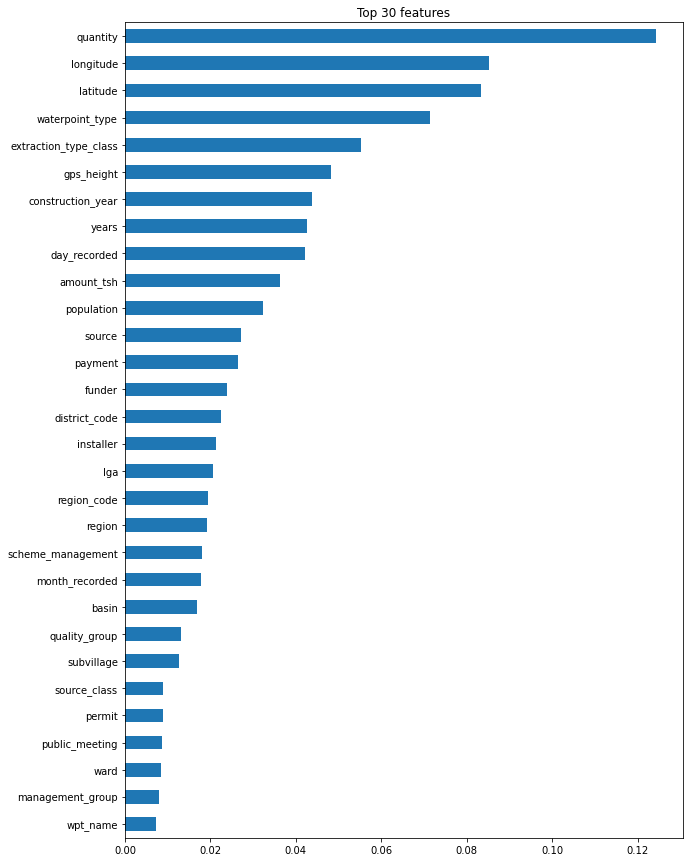

In [626]:
n = 30
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();